# Second Project for Computer Vision

# Image Captioning

#  Import Required Libraries

In [1]:
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import pandas as pd 
import string
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import imread, subplot, imshow, show
from pickle import dump
from tqdm import tqdm
import os
from pickle import load
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import load_model
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from IPython.display import display, Image      
from numpy import array
from numpy import argmax

Using TensorFlow backend.


# Data= Flicker Dataset

# **The First Part is related to extract the features of images by CNN and VGG16 model**

# ** Loading Images + Preprocessing Images (Resizing-Normalizing...) + Extracting Features of Images**

In [2]:
# Creating the model for extracting features of Images

def extract(dirname):

    model = VGG16()
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    print(model.summary())

    features = dict()

    for name in tqdm(os.listdir(dirname)):
        filename = dirname + '/' + name
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature

    return features



In [3]:
directory_name = "../input/flicker8k-dataset/flickr8k_dataset/Flicker8k_Dataset"
features = extract(directory_name)

print("Extracted Features: ", len(features))

# dumping features into a pickled file
dump(features, open('features.pkl', 'wb'))

553467904/553467096 [==============================] - 6s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

100%|██████████| 8091/8091 [03:08<00:00, 42.94it/s]


Extracted Features:  8091


# **The Second Part is related to documanets and captions**

# **Loading Document to Memory + Loading Descriptions + Cleaning Descriptions...**

In [4]:
# load doc into memory

def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
filename = "../input/flicker8k-dataset/flickr8k_text/Flickr8k.token.txt"

# load descriptions
doc = load_doc(filename)
print("Loaded: ", len(doc))

def load_descriptions(doc):
    mapping = dict()
    
    # process lines
    for line in doc.split('\n'):
        
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
            
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        
        # remove filename from image id
        image_id = image_id.split('.')[0]
        
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
            
        # store description
        mapping[image_id].append(image_desc)
    return mapping

def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] = ' '.join(desc)

def to_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

def save_vocabulary(vocab, filename):
    file = open(filename, 'w')
    for word in vocab:
        file.write(word+"\n")
    file.close()

def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)

    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
   

Loaded:  3395237


# **Print Loaded descriptions + Size of Vocabulary + Save them**

In [5]:
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

clean_descriptions(descriptions)
vocabulary = to_vocabulary(descriptions)
print("Vocabulary size: ", len(vocabulary))

save_vocabulary(vocabulary, "vocabulary.txt")
save_descriptions(descriptions, "descriptions.txt")

Loaded: 8092 
Vocabulary size:  8763


# **More cleaning Documents + Tokenization**

In [6]:
# tokenizer

from keras.preprocessing.text import Tokenizer

def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer



# **Train Data**

In [7]:
filename = "../input/flicker8k-dataset/flickr8k_text/Flickr_8k.trainImages.txt"
train = load_set(filename)
print('Dataset: %d' % len(train))

train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))


Dataset: 6000
Descriptions: train=6000


# **Test data**

In [8]:
filename = '../input/flicker8k-dataset/flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: ', len(test))

test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=', len(test_descriptions))


Dataset:  1000
Descriptions: test= 1000


# **Creating The model**

# **Extracting Features**

In [9]:
#function to load the photo features created using the VGG16 model
def load_photo_features(filename, photos):
    
    #this will load the entire features
    all_features = load(open(filename, 'rb'))
    
    #we are interested in loading the features of the required photos only
    features = {k: all_features[k] for k in photos}
    
    return features



In [10]:
filename = '../input/flicker8k-dataset/flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: ', len(test))

test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=', len(test_descriptions))

test_features = load_photo_features('features.pkl', test)
print('Photos: test=', len(test_features))


Dataset:  1000
Descriptions: test= 1000
Photos: test= 1000


In [11]:
filename = "../input/flicker8k-dataset/flickr8k_text/Flickr_8k.trainImages.txt"
train = load_set(filename)
print('Dataset: %d' % len(train))

train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

tokenizer = create_tokenizer(train_descriptions)

dump(tokenizer, open('tokenizer.pkl', 'wb'))

Dataset: 6000
Descriptions: train=6000


In [12]:
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 7579


In [13]:
def max_lengthTEMP(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)


max_length = max_lengthTEMP(train_descriptions)
print('Description Length: ', max_length)

Description Length:  34


# **Sequence processor**

In [14]:
def create_sequences(tokenizer, max_length, desc_list, photo):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

In [15]:
def load_photo_features(filename, photos):
    
    #this will load the entire features
    all_features = load(open(filename, 'rb'))
    
    #we are interested in loading the features of the required photos only
    features = {k: all_features[k] for k in photos}
    
    return features

filename = "../input/flicker8k-dataset/flickr8k_text/Flickr_8k.trainImages.txt"

In [16]:
def data_generator(descriptions, photos, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            photo = photos[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, photo)
            yield [[input_image, input_sequence], output_word]

# **Defining The Model**

In [17]:
def define_model(vocab_size, max_length):
    
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [18]:
filename = "../input/flicker8k-dataset/flickr8k_text/Flickr_8k.trainImages.txt"
train = load_set(filename)
print('Dataset: ', len(train))

train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))

train_features = load_photo_features('features.pkl', train)
print('Photos: train=', len(train_features))

tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size:', vocab_size)

max_length = max_lengthTEMP(train_descriptions)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs =1
steps = len(train_descriptions)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7579
Description Length:  34
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_2[0][0]      

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
6000/6000 [==============================] - 298s 50ms/step - loss: 4.6627


# **Evaluating The Model**

In [20]:
#this function maps an integer to a word

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

#The function below generates a description for a given photo as input.

def generate_desc(model, tokenizer, photo, max_length):
    #start tge generation process
    in_text = 'startseq'
    for i in range(max_length):
        
        #integer ncoding input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        
        #padding the input
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        #predicting next word
        prob = model.predict([photo,sequence], verbose=0)
        
        #converting the probability to integer
        prob = argmax(prob)
        
        #calling the word_for_id function in order to map integer to word
        word = word_for_id(prob, tokenizer)
        
        #breaking if word cannot be mapped
        if word is None:
            break
        #appending as input
        in_text += ' ' + word
        #break if end is predicted
        if word == 'endseq':
            break
    return in_text

# **BLUE Metric Evaluation**

In [21]:
#the below function evaluates the model

def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    for key, desc_list in descriptions.items():
        prediction = generate_desc(model, tokenizer, photos[key], max_length)
        actual_desc = [d.split() for d in desc_list]
        actual.append(actual_desc)
        predicted.append(prediction.split())

    print('BLEU-1: ', corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: ', corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: ', corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: ', corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [22]:
filename = "../input/flicker8k-dataset/flickr8k_text/Flickr_8k.trainImages.txt"
train = load_set(filename)
print('Dataset: ', len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ', vocab_size)
max_length = max_lengthTEMP(train_descriptions)
print('Description Length: ,', max_length)

Dataset:  6000
Descriptions: train= 6000
Vocabulary Size:  7579
Description Length: , 34


In [23]:
filename = '../input/flicker8k-dataset/flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: ', len(test))
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=', len(test_descriptions))
test_features = load_photo_features('features.pkl', test)
print('Photos: test=', len(test_features))



Dataset:  1000
Descriptions: test= 1000
Photos: test= 1000


In [25]:
from nltk.translate.bleu_score import corpus_bleu

filename = 'model_0.h5'
model = load_model(filename)
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


BLEU-1:  0.5656898893848243
BLEU-2:  0.29565629294224116
BLEU-3:  0.19244548457757146
BLEU-4:  0.08034850199208345


# **Generate descriptions for an image**

In [26]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)
 
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions
 
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# load training dataset (6K)
filename = '../input/flicker8k-dataset/flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Dataset: 6000
Descriptions: train=6000


In [27]:
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34

In [ ]:
# load the model
model = load_model('model_0.h5')

In [28]:
# extract features from each photo in the directory
def extract_features(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature
 
# load and prepare the photograph
photo = extract_features('../input/imagess/images.jpg')

# Sample generated descriptions for following images

In [29]:
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq two dogs are playing on the grass endseq


Text(0.5, 1.0, 'startseq two dogs are playing on the grass endseq')

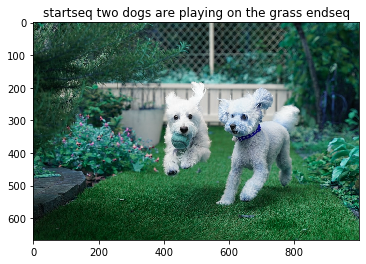

In [16]:
img=load_img('../input/imagess/images.jpg')
plt.imshow(img)
plt.title(description)

In [31]:
# load and prepare the photograph
photo = extract_features('../input/flicker8k-dataset/flickr8k_dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg')
# generate description
description1 = generate_desc(model, tokenizer, photo, max_length)
print(description1)

startseq man in red shirt is playing on the street endseq


Text(0.5, 1.0, 'startseq man in red shirt is playing on the street endseq')

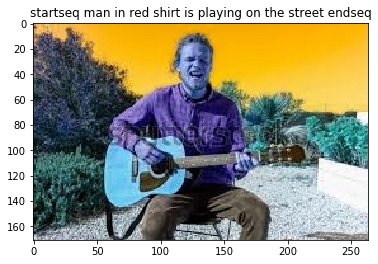

In [19]:
img2=load_img('../input/redshirt/redshirt.jpg')
plt.imshow(img2)
plt.title(description1)